## Data Visualization

Importig libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from payment_optimizer.modeling.models import *
import seaborn as sns
from payment_optimizer.db.sql_interactions import *

Connecting to database e_commerce

In [2]:
# Get the current directory
current_dir = os.getcwd()

db_path = os.path.join(current_dir, 'e_commerce')
data_connect = DatabaseConnector(db_path)
data = data_connect.join_tables()

2024-04-25 23:32:26,768 - sql_interactions.py - get_table_columns - INFO - (the list of columns: ['transaction_id', 'user_id', 'payment_method_id', 'rating_id', 'status', 'type', 'shipping_address', 'explored_bandit_type']) - line: 67
2024-04-25 23:32:26,932 - sql_interactions.py - close_cnxn - INFO - (commiting the changes) - line: 34
2024-04-25 23:32:26,935 - sql_interactions.py - close_cnxn - INFO - (the connection has been closed) - line: 37
2024-04-25 23:32:26,938 - sql_interactions.py - get_table_columns - INFO - (the list of columns: ['transaction_id', 'product_id', 'quantity', 'date']) - line: 67
2024-04-25 23:32:27,004 - sql_interactions.py - close_cnxn - INFO - (commiting the changes) - line: 34
2024-04-25 23:32:27,009 - sql_interactions.py - close_cnxn - INFO - (the connection has been closed) - line: 37
2024-04-25 23:32:27,014 - sql_interactions.py - get_table_columns - INFO - (the list of columns: ['product_id', 'product_name', 'brand', 'price']) - line: 67
2024-04-25 23:3

### Visualization of status of purchase

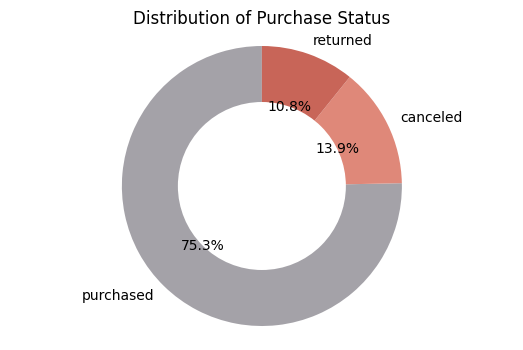

In [3]:
# Count the occurrences of each unique value in the 'status' column
status_counts = data['status'].value_counts()

color =["#a4a2a8", "#df8879", "#c86558"]


# Create a donut chart
plt.figure(figsize=(6.5, 4))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=color)
# Draw a circle at the center of the pie to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.6, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Distribution of Purchase Status')
plt.show()

According to the graph, 75.3% of the products have been purchased, 14.8% have been canceled, and only 10% percent have been returned. Hence, overall, the company succeeded in providing products with good quality.

### Number of purchases with each Bandit with type of payment.

<Figure size 600x300 with 0 Axes>

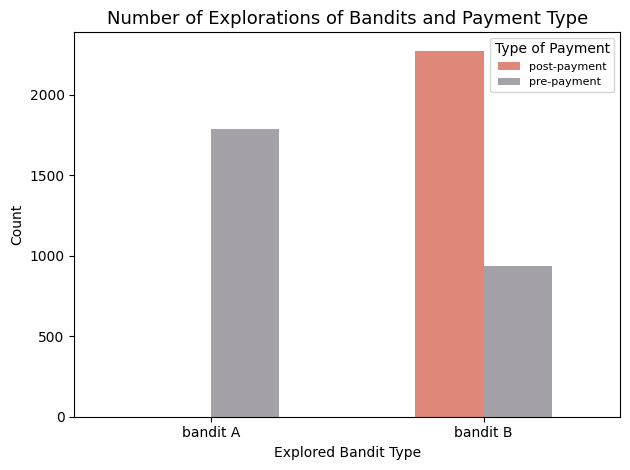

In [4]:
# Group the data by 'explored_bandit_type' and 'type', then count the occurrences
grouped_data = data.groupby(['explored_bandit_type', 'type']).size().unstack(fill_value=0)

color = ["#df8879", "#a4a2a8"]

# Create the grouped bar plot
plt.figure(figsize=(6, 3))
grouped_data.plot(kind='bar', color=color)
plt.xlabel('Explored Bandit Type', fontsize=10)  # Adjust fontsize here
plt.ylabel('Count', fontsize=10)  # Adjust fontsize here
plt.title('Number of Explorations of Bandits and Payment Type', fontsize=13)  # Adjust fontsize here
plt.xticks(rotation=0)  # No rotation needed as we specified the order
plt.legend(title='Type of Payment', fontsize=8)  # Adjust fontsize here
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


The plot indicates that the number of purchases with Bandit B exceeds the Bandit A. Moreover, the users who prefer paying beforehand, most of the cases prefer Bandit A.

### Total Revenue generated with each Bandit

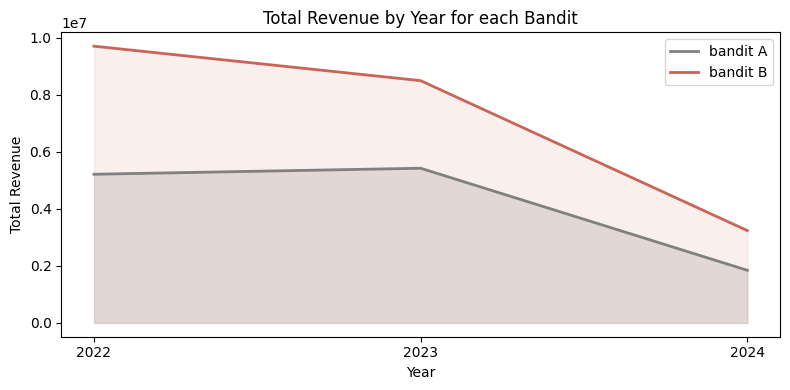

In [5]:
# Convert 'date' column to datetime if it's not already in datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the year from the 'date' column
data['year'] = data['date'].dt.year

data["revenue"] = data["price"] * data["quantity"]
# Group data by 'year' and 'explored_bandit_type' and calculate the total revenue for each group
revenue_by_bandit_year = data.groupby(['year', 'explored_bandit_type'])['revenue'].sum()

# Create the line chart
plt.figure(figsize=(8, 4))

# Plot a separate line for each bandit type
for bandit_type, color in zip(revenue_by_bandit_year.unstack().columns, ['grey', '#c86558']):  # Choose your colors
    # Plot the line
    plt.plot(revenue_by_bandit_year.unstack()[bandit_type], color=color, label=bandit_type, linewidth=2)
    # Fill the area under the line with a light grey color for the grey line and a lighter version of the line color for the other line
    if color == 'grey':
        plt.fill_between(revenue_by_bandit_year.unstack().index, revenue_by_bandit_year.unstack()[bandit_type], color='lightgrey', alpha=0.6)
    else:
        plt.fill_between(revenue_by_bandit_year.unstack().index, revenue_by_bandit_year.unstack()[bandit_type], color=color, alpha=0.1)

plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Year for each Bandit')
plt.legend()
plt.xticks([2022, 2023, 2024])

plt.tight_layout()
plt.show()

The total revenue generated by Bandit B is considerably higher than the one generated by Bandit A in all over th years.
Let's explore the T-test result to better understand whether bandit B is beneficial for the business.

### A/B testing result

In [6]:
ab_test = ABTesting(data_connect)
ab_test.preprocess_data()
ab_test.perform_ab_test()
res = ab_test.results()
t_stat = res["t_test"]
p_value = res["p_value"]

In [7]:
# Set display options to show the full content of the "message" column
pd.set_option('display.max_colwidth', None)

# Fetch data from data_connect
ab_test = data_connect.data_fetcher("a_b_testing_results")

# Round "t_test" and "p_value" columns to two decimal places
ab_test["t_test"] = ab_test["t_test"].round(3)
ab_test["p_value"] = ab_test["p_value"].round(3)

# Extract the last 5 words from the "message" column
ab_test["message"] = ab_test["message"].apply(lambda x: ' '.join(x.split()[-7:]))


2024-04-25 23:32:31,154 - sql_interactions.py - get_table_columns - INFO - (the list of columns: ['result_id', 'start_date', 'end_date', 't_test', 'p_value', 'message', 'test_date']) - line: 67
2024-04-25 23:32:31,161 - sql_interactions.py - close_cnxn - INFO - (commiting the changes) - line: 34
2024-04-25 23:32:31,167 - sql_interactions.py - close_cnxn - INFO - (the connection has been closed) - line: 37


In [8]:
# Print the selected columns
print(ab_test[["t_test", "p_value", "message"]])

   t_test  p_value                               message
0  -1.587    0.056  Revenue Bandit A < Revenue Bandit B.
1  -0.728    0.233  Revenue Bandit A < Revenue Bandit B.
2  -1.270    0.102  Revenue Bandit A < Revenue Bandit B.


The A/B testing was conducted three times for different time intervals, and according to all of the test results, we rejected our Null Hypothesis (Revnue A = Reveue B).

- The negative t-statistic indicates that Bandit A has significantly lower revenue than Bandit B.
- The low p-value suggests that the difference in revenue between Bandit A and Bandit B is statistically significant.

In summary, the A/B test results suggest that providing pre- and post-payment options (Bandit B) leads to higher revenue than offering only pre-payment options (Bandit A). Therefore, it would be advisable to prioritize Bandit B for revenue optimization purposes.